In [9]:
import keras

In [10]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()

In [11]:
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y  

In [12]:
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import Input, Dense, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128]):
    input_layer = Input(input_shape)
    
    for i, num_unit in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=num_unit, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=num_unit, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [17]:
import tensorflow as tf
import keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [32]:
import tensorflow as tf 
import keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
"""
def combined_loss(gamma=2., alpha=4., fl_w=0.3, ce_w=0.7):
    gamma = float(gamma)
    alpha = float(alpha)
    def combined_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out),gamma))
        f1 = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(f1, axis=1)
        crossEntropy = keras.losses.categorical_crossentropy(y_true, y_pred)
        return fl_w * tf.reduce_mean(reduced_fl) + ce_w * crossEntropy
    return combined_loss_fixed

In [26]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss=focal_loss(), metrics=['accuracy'], optimizer=optimizer)

model.fit(x_train,y_train, epochs=EPOCHS, batch_size=BATCH_SIZE
          , validation_data=(x_test,y_test),shuffle=True)

train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.0782 - acc: 0.9946 - val_loss: 6.2372 - val_acc: 0.4859


In [33]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss=combined_loss(), metrics=['accuracy'], optimizer=optimizer)

model.fit(x_train,y_train, epochs=EPOCHS, batch_size=BATCH_SIZE
          , validation_data=(x_test,y_test),shuffle=True)

train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.3070 - acc: 0.9500 - val_loss: 3.1208 - val_acc: 0.4797


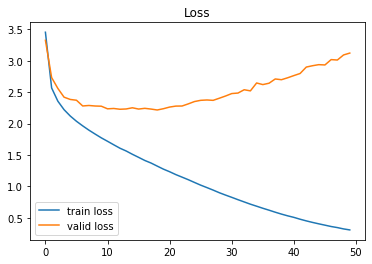

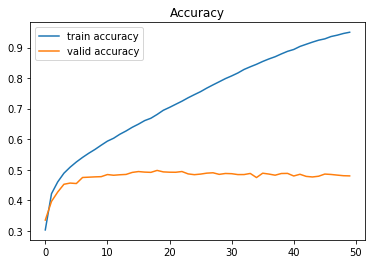

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()
